# Defining suggestions for segmentations

As was mentioned on "`02_ab_tesst_analysis.ipynb`" file, I suggest a new test with multiple groups. For some of these groups are necesasry a deeper understanding in a segmentation. 

<br></br>
### RFM Segmentation 

**What is?**

RFM segmentation (Recency, Frequency, Monetary) is a data-driven technique used in marketing and customer analytics to classify customers based on their purchasing behavior. It evaluates:

- Recency (R): How recently a customer made a purchase
- Frequency (F): How often a customer makes purchases.
- Monetary (M): How much a customer spends.

By scoring customers on these three dimensions, businesses can identify high-value customers, predict churn, and tailor marketing strategies effectively.

I'll discuss more details of how it works later on. 


<br></br>

# Loading Data

In [20]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import os 

In [2]:
df_orders = pd.read_parquet("../data/processed/orders_processed.parquet")
df_ab_test = pd.read_parquet("../data/processed/ab_test.parquet")
df_consumers = pd.read_parquet("../data/processed/consumers_processed.parquet")

## Calculating RFM Metrics

### Limitations

- As we can see bellow, we have the same amount of users on the dim file than in the orders.
- This means that I only have access to the "active" users as to be in "orders" the user did at least 1 order 
- Also, the database hasn't quartis well defined 

> Which will impact the rfm segmentation as this segmentation need to have access to all users in the database


### Solution

- Due to these data limitation I've changed the classification
- After a lot of testing my solution was to, instead of use quartis as normally this segmentation requires, I'm using flags on Recency, Frequency and total value as Monetary
- Also, as I've identified in the "ab test analysis", the Average Order Value hasn't change even with the coupon that was used, so, some flags and classification was created thinking on that


In [3]:
# Amount of consumers that we have in this dim
df_consumers.shape

(806156, 7)

In [4]:
# Amount of consumers that we hae in our orders
df_orders["customer_id"].nunique()

806466

In [5]:
# First, calculate the three core metrics for each customer:

# Set the analysis end date 
analysis_end_date = df_orders['order_created_at'].max()

# Calculate RFM metrics
rfm = df_orders.groupby('customer_id').agg({
    'order_created_at': lambda x: (analysis_end_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'order_total_amount': 'mean'  # Monetary (using average order value)
}).reset_index()

# Also calculate total spend for additional context
rfm['total_spend'] = df_orders.groupby('customer_id')['order_total_amount'].sum().reset_index()['order_total_amount']

# Rename columns
rfm.columns = ['customer_id', 'recency_days', 'frequency', 'monetary', 'total_spend']

rfm.head()


,customer_id,recency_days,frequency,monetary,total_spend
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,6,8,34.125000,273.00
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,2,3,57.966667,173.90
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,2,2,34.325000,68.65
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,17,1,88.800000,88.80
4,00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45...,7,5,106.620000,533.10


In [6]:
# Quartis too similar, imposibilitating the "traditional" RFM 
rfm["frequency"].describe()

count    806466.000000
mean          3.009941
std           3.747375
min           1.000000
25%           1.000000
50%           2.000000
75%           3.000000
max         157.000000
Name: frequency, dtype: float64

### Recreating using new logic after extense tests with the available datasets

In [7]:
# Calculate RFM Metrics

#===========================
# Set the analysis end date 
#===========================
analysis_end_date = df_orders['order_created_at'].max()


#===========================
# Calculate RFM metrics
#===========================
rfm = df_orders.groupby('customer_id').agg({
    'order_created_at': lambda x: (analysis_end_date - x.max()).days,  # Recency
    'order_id': 'count',  # Frequency
    'order_total_amount': 'mean'  # Monetary (using average order value)
}).reset_index()


#===========================
# Also calculate total spend for additional context
#===========================
rfm['total_spend'] = df_orders.groupby('customer_id')['order_total_amount'].sum().reset_index()['order_total_amount']


#===========================
# Rename columns
#===========================
rfm.columns = ['customer_id', 'recency_days', 'frequency', 'avg_order_value', 'total_spend']


rfm.head()

,customer_id,recency_days,frequency,avg_order_value,total_spend
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,6,8,34.125000,273.00
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,2,3,57.966667,173.90
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,2,2,34.325000,68.65
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,17,1,88.800000,88.80
4,00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45...,7,5,106.620000,533.10


In [11]:
#Create Binary Segment Indicators

# Define thresholds based on specific needs of this dataset; Changing some numbers that is usually the default 
#   For example, rececency is usually 30, 30-60 for inactive and for new is if the first order **ever** was in the last 30-60 days
#   I've to change to lower values

#======================
# Recency thresholds
#======================
recent_threshold = 7                          # Consider active if ordered in last 7 days
rfm['is_active'] = rfm['recency_days'] <= recent_threshold
rfm['is_inactive'] = rfm['recency_days'] > 15 # Inactive if no orders in 15+ days


#======================
# Frequency thresholds
#======================
high_freq_threshold = rfm['frequency'].quantile(0.75)  # Top 25% by frequency
low_freq_threshold = rfm['frequency'].quantile(0.25)   # Bottom 25% by frequency
rfm['is_high_frequency'] = rfm['frequency'] >= high_freq_threshold
rfm['is_low_frequency'] = rfm['frequency'] <= low_freq_threshold


#======================
# AOV (Average Order Value) thresholds
#======================
high_aov_threshold = rfm['avg_order_value'].quantile(0.75)  # Top 25% by AOV
low_aov_threshold = rfm['avg_order_value'].quantile(0.25)   # Bottom 25% by AOV
rfm['is_high_aov'] = rfm['avg_order_value'] >= high_aov_threshold
rfm['is_low_aov'] = rfm['avg_order_value'] <= low_aov_threshold

#======================
# Total value thresholds
#======================
high_value_threshold = rfm['total_spend'].quantile(0.75)  # Top 25% by total spend
rfm['is_high_value'] = rfm['total_spend'] >= high_value_threshold

# New customer indicator (low frequency but recent)
rfm['is_new'] = (rfm['frequency'] <= 3) & (rfm['recency_days'] <= 20)

rfm.head()

,customer_id,recency_days,frequency,avg_order_value,total_spend,is_active,is_inactive,is_high_frequency,is_low_frequency,is_high_aov,is_low_aov,is_high_value,is_new
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,6,8,34.125000,273.00,True,False,True,False,False,False,True,False
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,2,3,57.966667,173.90,True,False,True,False,True,False,True,True
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,2,2,34.325000,68.65,True,False,False,False,False,False,False,True
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,17,1,88.800000,88.80,False,True,False,True,True,False,False,True
4,00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45...,7,5,106.620000,533.10,True,False,True,False,True,False,True,False


### This is the groupings that I've comme up due to the limitations

| Condition                                             | Segment                     |
|------------------------------------------------------|-----------------------------|
| is_high_frequency and is_low_aov and is_active      | Frequent Small Baskets      |
| is_low_frequency and is_high_aov and is_active      | Big Spenders, Rare Visits   |
| is_high_value and not is_active and not is_inactive | At-Risk High Value          |
| is_high_value and is_inactive                       | Churned High Value          |
| is_new                                              | New Explorers               |
| is_high_frequency and is_high_aov and is_active     | VIP Customers               |
| is_active and not is_low_frequency and not is_high_frequency | Core Customers       |
| is_inactive and not is_high_value                   | Dormant Low Value           |
| else                                                | Other Customers             |



In [12]:

#======================
# Create Hybrid Segments
#======================

def create_hybrid_segment(row):
    # High-Frequency, Low-AOV Segment 
    # Frequent users with small orders; encourage higher-value orders
    if row['is_high_frequency'] and row['is_low_aov'] and row['is_active']:
        return 'Frequent Small Baskets'
    
    # Low-Frequency, High-AOV Segment (needs frequency focused incentives)
    # Infrequent users with high-value orders; encourage more frequent purchases
    elif row['is_low_frequency'] and row['is_high_aov'] and row['is_active']:
        return 'Big Spenders, Rare Visits'
    
    # High-Value, Recently Inactive (didnt had an order in the last 7-15 days; 15+ would be considered inactive)
    # High-value users who recently became inactive; target with backflow campaigns
    elif row['is_high_value'] and not row['is_active'] and not row['is_inactive']:
        return 'At-Risk High Value'
    
    # High-Value, Long Inactive (needs aggressive backflow)
    # High-value users who have been inactive for a longer time; may require strong re-engagement
    elif row['is_high_value'] and row['is_inactive']:
        return 'Churned High Value'
    
    # New Customers (needs onboarding incentives), focus on onboarding and engagement
    # New customers exploring the platform; here is limit we need first order date to be precise
    elif row['is_new']:
        return 'New Explorers'
    
    # Consistent High-Value Customers 
    # Loyal high-value users; reinforce engagement with loyalty programs
    elif row['is_high_frequency'] and row['is_high_aov'] and row['is_active']:
        return 'VIP Customers'
    
    # Average Active Customers (needs general growth incentives)
    # Regular users with stable engagement; nurture them for long-term retention
    elif row['is_active'] and not row['is_low_frequency'] and not row['is_high_frequency']:
        return 'Core Customers'
    
    # Low-Value Inactive (needs reactivation but lower priority)
    # Low-value users who are inactive; lower priority for reactivation efforts
    elif row['is_inactive'] and not row['is_high_value']:
        return 'Dormant Low Value'
        
    # High Frequency, Medium AOV - Active customers with high frequency but neither high nor low AOV
    elif row['is_high_frequency'] and not row['is_high_aov'] and not row['is_low_aov'] and row['is_active']:
        return 'Frequent Medium Spenders'
    
    # Medium Frequency, Medium AOV - Stable customers with moderate engagement and spending
    elif not row['is_high_frequency'] and not row['is_low_frequency'] and not row['is_high_aov'] and not row['is_low_aov'] and row['is_active']:
        return 'Steady Customers'
    
    # Recently Active, Inconsistent Pattern - Customers who are active but have inconsistent patterns
    elif row['is_active'] and not row['is_new']:
        return 'Active Inconsistent'
    
    # Catch-all for any remaining customers
    # Default category for any users who do not fit other segments
    else:
        return 'Other Customers'

# Apply the segmentation function
rfm['hybrid_segment'] = rfm.apply(create_hybrid_segment, axis=1)


rfm.head()

,customer_id,recency_days,frequency,avg_order_value,total_spend,is_active,is_inactive,is_high_frequency,is_low_frequency,is_high_aov,is_low_aov,is_high_value,is_new,hybrid_segment
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,6,8,34.125000,273.00,True,False,True,False,False,False,True,False,Frequent Medium Spenders
1,000021924bf8192f64a7cc17ce7c0bc511cba907308f80...,2,3,57.966667,173.90,True,False,True,False,True,False,True,True,New Explorers
2,000022ced2f3aa411b66ac41167b272ae528c4acdffeeb...,2,2,34.325000,68.65,True,False,False,False,False,False,False,True,New Explorers
3,000032b594523c3f8868edee4f1577b157e115cd01ab31...,17,1,88.800000,88.80,False,True,False,True,True,False,False,True,New Explorers
4,00006f567cb362ba98b0a23d9f9f73122e9ad98c9edb45...,7,5,106.620000,533.10,True,False,True,False,True,False,True,False,VIP Customers


In [13]:
# Analyze Segment Characteristics
# Verifying the characteristics of each segment to validate the grouping and refine incentive strategies if necessary:

# Calculate segment metrics
df_segment_profile = rfm.groupby('hybrid_segment').agg({
    'customer_id': 'count',
    'recency_days': 'mean',
    'frequency': 'mean',
    'avg_order_value': 'mean',
    'total_spend': 'mean'
}).reset_index()
df_segment_profile = df_segment_profile.rename(columns={'total_spend':'avg_total_spend'})


# Calculate percentage of total customer base
df_segment_profile['pct_customers'] = df_segment_profile['customer_id'] / df_segment_profile['customer_id'].sum() * 100

# Sort by customer count to see largest segments first
df_segment_profile = df_segment_profile.sort_values('customer_id', ascending=False)

df_segment_profile.head(15)

,hybrid_segment,customer_id,recency_days,frequency,avg_order_value,avg_total_spend,pct_customers
6,New Explorers,413172,8.983285,1.589946,43.204784,70.538814,51.232414
3,Dormant Low Value,142780,24.671999,1.217895,44.655880,52.514530,17.704404
4,Frequent Medium Spenders,88477,2.262780,8.262565,41.848715,345.294131,10.970952
5,Frequent Small Baskets,42307,2.593944,6.883022,23.410527,162.074049,5.245974
8,VIP Customers,41368,2.171413,8.073197,80.748323,648.859897,5.129540
0,At-Risk High Value,31969,10.526760,4.439707,75.400101,277.323290,3.964085
1,"Big Spenders, Rare Visits",25657,3.163893,1.000000,90.643976,90.643976,3.181411
2,Churned High Value,12637,19.948564,2.904645,112.302427,245.983001,1.566960
7,Other Customers,8099,10.598345,4.455859,27.420296,119.783013,1.004258


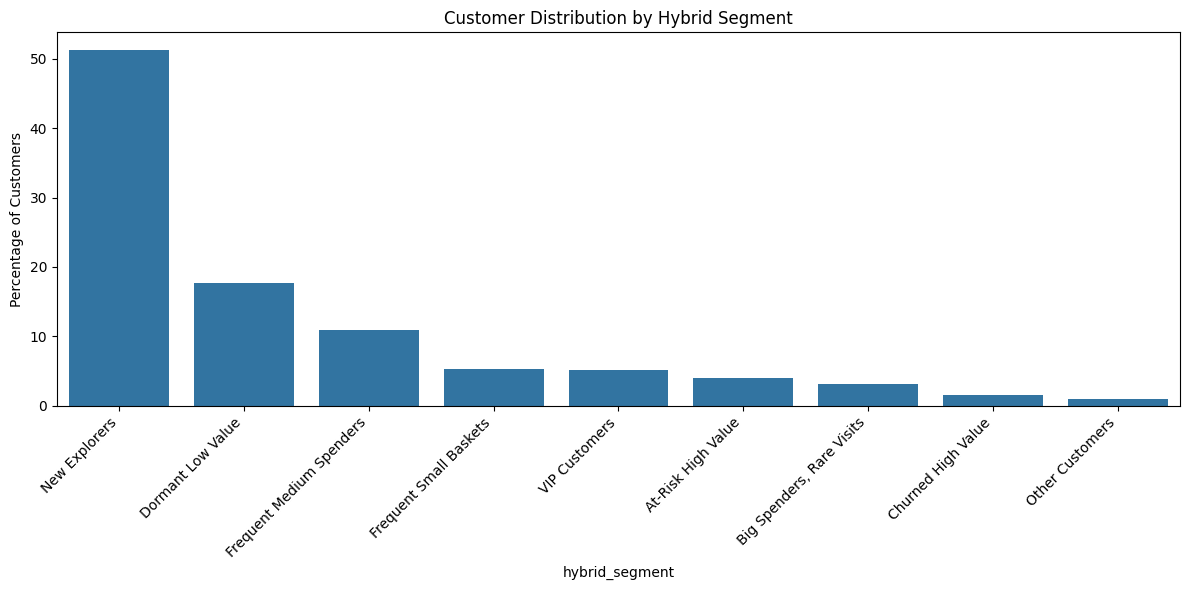

C:\Users\Henrique Hashimoto\AppData\Local\Temp\ipykernel_15824\2274048268.py:34: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hybrid_segment', y='recency_days', data=df_segment_profile, ax=axes[0, 0],
C:\Users\Henrique Hashimoto\AppData\Local\Temp\ipykernel_15824\2274048268.py:37: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')
C:\Users\Henrique Hashimoto\AppData\Local\Temp\ipykernel_15824\2274048268.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='hybrid_segment', y='frequency', data=df_segment_profile, ax=axes[0, 1]

<Figure size 1400x1000 with 0 Axes>

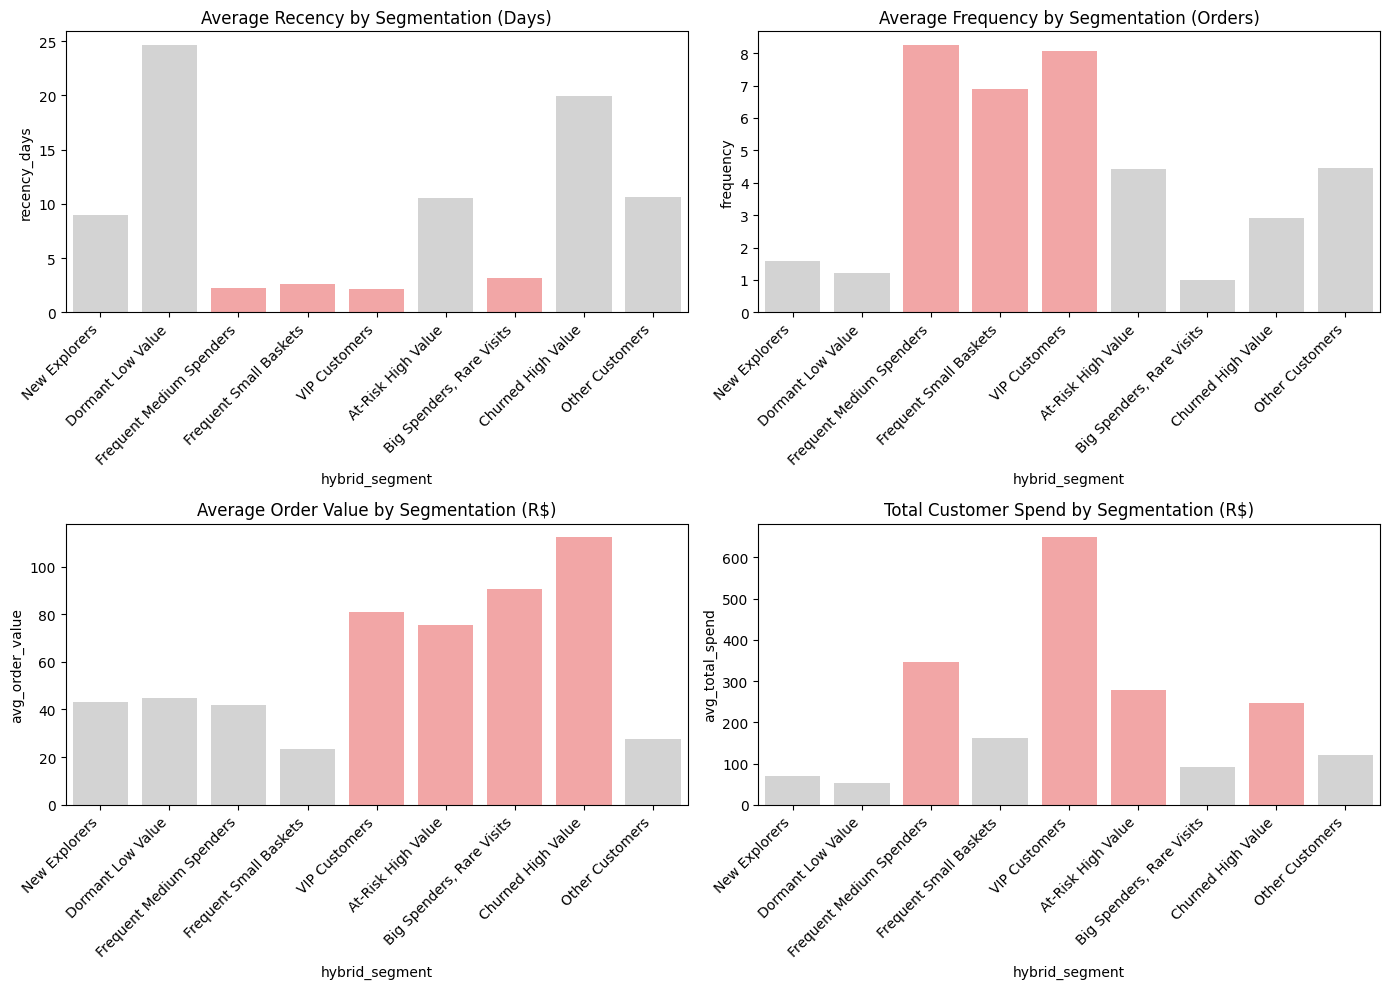

In [23]:
# Visualize Segment Distribution

# Amount of customers per classification
plt.figure(figsize=(12, 6))
sns.barplot(x = 'hybrid_segment', y = 'pct_customers', data = df_segment_profile)
plt.title('Customer Distribution by Hybrid Segment')
plt.xticks(rotation = 45, ha = 'right')
plt.ylabel('Percentage of Customers')
plt.tight_layout()
plt.show()


# Define the highlight segments for each plot
highlight_segments = {
    "recency_days": ["VIP Customers", "Frequent Medium Spenders", "Frequent Small Baskets", "Big Spenders, Rare Visits"],
    "frequency": ["Frequent Medium Spenders", "Frequent Small Baskets", "VIP Customers"],
    "avg_order_value": ["VIP Customers", "At-Risk High Value", "Big Spenders, Rare Visits", "Churned High Value"],
    "avg_total_spend": ["Frequent Medium Spenders", "VIP Customers", "At-Risk High Value", "Churned High Value"]
}

# Function to assign colors based on the plot type
def get_colors(data, column, highlight_list):
    return [("#ff9999" if segment in highlight_list else "#d3d3d3") for segment in data[column]]

#===============================
# Segment classification characteristics visualization
#===============================
plt.figure(figsize=(14, 10))
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

#-------------------
# Recency by segment
#-------------------
sns.barplot(x='hybrid_segment', y='recency_days', data=df_segment_profile, ax=axes[0, 0], 
            palette=get_colors(df_segment_profile, "hybrid_segment", highlight_segments["recency_days"]))
axes[0, 0].set_title('Average Recency by Segmentation (Days)')
axes[0, 0].set_xticklabels(axes[0, 0].get_xticklabels(), rotation=45, ha='right')

#-------------------
# Frequency by segment
#-------------------
sns.barplot(x='hybrid_segment', y='frequency', data=df_segment_profile, ax=axes[0, 1], 
            palette=get_colors(df_segment_profile, "hybrid_segment", highlight_segments["frequency"]))
axes[0, 1].set_title('Average Frequency by Segmentation (Orders)')
axes[0, 1].set_xticklabels(axes[0, 1].get_xticklabels(), rotation=45, ha='right')

#-------------------
# AOV by segment
#-------------------
sns.barplot(x='hybrid_segment', y='avg_order_value', data=df_segment_profile, ax=axes[1, 0], 
            palette=get_colors(df_segment_profile, "hybrid_segment", highlight_segments["avg_order_value"]))
axes[1, 0].set_title('Average Order Value by Segmentation (R$)')
axes[1, 0].set_xticklabels(axes[1, 0].get_xticklabels(), rotation=45, ha='right')

#-------------------
# Total spend by segment
#-------------------
sns.barplot(x='hybrid_segment', y='avg_total_spend', data=df_segment_profile, ax=axes[1, 1], 
            palette=get_colors(df_segment_profile, "hybrid_segment", highlight_segments["avg_total_spend"]))
axes[1, 1].set_title('Total Customer Spend by Segmentation (R$)')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')

plt.tight_layout()

output_path = "imgs/hybrid_segments_highlight.png"
os.makedirs(os.path.dirname(output_path), exist_ok=True)

# Save the picturree
plt.savefig(output_path, dpi=300, bbox_inches='tight')


plt.show()

<br></br>
# Some insights that we can extract from the analyis above

### Segment Distribution:

**1) Customer Distribution:**

- "`New Explorers`" is the dominant segment (51.23%), confirming the database limitations noted earlier
- "`Dormant Low Value`" is the second largest segment (17.70%), indicating a significant portion of the customer base that needs reactivation
- "`Frequent Medium Spenders`" (10.97%) has emerged as an important segment that was previously hidden in the "Other Customers" category

**2) Engagement Patterns:**

- "`Frequent Medium Spenders`" shows high frequency (8.26 orders) with moderate AOV (R$41.85), revealing a valuable segment that orders frequently with medium sized price
- "`VIP Customers`" are high frequency (8.07 orders) and highest AOV (R$80.75)
- The remaining "`Other Customers`" shows more moderate frequency (4.46 orders) and lower AOV (R$27.42), indicating these are truly customers with inconsistent patterns

**3) Value Distribution:**

- "`Frequent Medium Spenders`" have a high total spend (R$345.29), making them the second most valuable segment after "VIP Customers" (R$648.86)

**4) Recency Insights:**

- "`Frequent Medium Spenders`" have good recency (2.26 days), even better than "VIP Customers" (2.17 days), showing they are highly engaged
- The remaining "`Other Customers`" have moderate recency (10.60 days), indicating they're not as engaged as the identified segments




In [15]:
# Create a Segment Migration Strategy
# Define pathways for customers to move between segments:
# Define ideal segment progression paths
segment_progression = {
    'New Explorers': ['Core Customers', 'Frequent Small Baskets', 'VIP Customers'],
    'Frequent Small Baskets': ['Core Customers', 'VIP Customers'],
    'Big Spenders, Rare Visits': ['Core Customers', 'VIP Customers'],
    'Core Customers': ['VIP Customers'],
    'Dormant Low Value': ['Core Customers', 'Frequent Small Baskets'],
    'At-Risk High Value': ['VIP Customers', 'Core Customers'],
    'Churned High Value': ['At-Risk High Value', 'Core Customers', 'VIP Customers']
}

# Visualize the segment progression paths
# (This would require a network visualization library like networkx)

In [16]:
# Implement A/B Testing Framework
# Set up your A/B test to evaluate the effectiveness of the hybrid segment-based approach:

# For each segment, create test and control groups
segments = rfm['hybrid_segment'].unique()
test_assignment = {}

for segment in segments:
    # Get customers in this segment
    segment_customers = rfm[rfm['hybrid_segment'] == segment]['customer_id'].tolist()
    
    # Randomly assign to test or control (80% test, 20% control)
    np.random.seed(42)  # For reproducibility
    test_mask = np.random.choice([True, False], size=len(segment_customers), p=[0.8, 0.2])
    
    test_customers = [customer for i, customer in enumerate(segment_customers) if test_mask[i]]
    control_customers = [customer for i, customer in enumerate(segment_customers) if not test_mask[i]]
    
    test_assignment[segment] = {
        'test_customers': test_customers,
        'control_customers': control_customers,
        'incentive_strategy': incentive_mapping[segment]['strategy'],
        'incentive_example': incentive_mapping[segment]['example']
    }

# Create a dataframe with test assignments for implementation
test_assignment_df = []
for segment, data in test_assignment.items():
    for customer in data['test_customers']:
        test_assignment_df.append({
            'customer_id': customer,
            'segment': segment,
            'test_group': 'test',
            'incentive_strategy': data['incentive_strategy'],
            'incentive_example': data['incentive_example']
        })
    for customer in data['control_customers']:
        test_assignment_df.append({
            'customer_id': customer,
            'segment': segment,
            'test_group': 'control',
            'incentive_strategy': 'No incentive (control)',
            'incentive_example': 'No incentive (control)'
        })

test_assignment_df = pd.DataFrame(test_assignment_df)
test_assignment_df.head()

,customer_id,segment,test_group,incentive_strategy,incentive_example
0,000009e29b12d8c5b9c9579e21384320c2df3bd935f19e...,Frequent Medium Spenders,test,Incentives for both higher AOV and sustained f...,Spend R$10 more than your average order and ge...
1,00045b72e5cd7d138ed229abf53af84403593a103ddb33...,Frequent Medium Spenders,test,Incentives for both higher AOV and sustained f...,Spend R$10 more than your average order and ge...
2,0004ef68b0899596d1bd9528a9b5fe9908049aa8a7399d...,Frequent Medium Spenders,test,Incentives for both higher AOV and sustained f...,Spend R$10 more than your average order and ge...
3,000665b51743dcbea5b596557436ed119d1c92dc99876d...,Frequent Medium Spenders,test,Incentives for both higher AOV and sustained f...,Spend R$10 more than your average order and ge...
4,000768a0b340c5633d9a7d2b09cfdaef3a30cdbce1e159...,Frequent Medium Spenders,test,Incentives for both higher AOV and sustained f...,Spend R$10 more than your average order and ge...


In [17]:
# Define Segment-Specific Success Metrics
# Create a measurement framework tailored to each segment's goals:

segment_metrics = {
    'Frequent Small Baskets': {
        'primary_metric': 'avg_order_value',
        'secondary_metrics': ['orders_per_month', 'retention_rate'],
        'success_threshold': 'AOV increase of 15%+'
    },
    'Big Spenders, Rare Visits': {
        'primary_metric': 'orders_per_month',
        'secondary_metrics': ['avg_order_value', 'days_between_orders'],
        'success_threshold': 'Frequency increase of 30%+'
    },
    'At-Risk High Value': {
        'primary_metric': 'retention_rate',
        'secondary_metrics': ['orders_per_month', 'avg_order_value'],
        'success_threshold': 'Retention increase of 40%+'
    },
    'Churned High Value': {
        'primary_metric': 'reactivation_rate',
        'secondary_metrics': ['orders_after_reactivation', 'avg_order_value'],
        'success_threshold': 'Reactivation of 25%+ of segment'
    },
    'New Explorers': {
        'primary_metric': 'category_diversity',
        'secondary_metrics': ['retention_rate', 'orders_per_month'],
        'success_threshold': 'Average of 3+ categories tried'
    },
    'VIP Customers': {
        'primary_metric': 'share_of_wallet',
        'secondary_metrics': ['avg_order_value', 'orders_per_month'],
        'success_threshold': 'AOV increase of 10%+'
    },
    'Core Customers': {
        'primary_metric': 'customer_value_growth',
        'secondary_metrics': ['orders_per_month', 'avg_order_value'],
        'success_threshold': 'Value growth of 20%+'
    },
    'Dormant Low Value': {
        'primary_metric': 'reactivation_rate',
        'secondary_metrics': ['orders_after_reactivation'],
        'success_threshold': 'Reactivation of 15%+ of segment'
    }
}